In [111]:
import pyreadstat
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

from group_lasso import LogisticGroupLasso, GroupLasso

In [ ]:
# reading the dataset with CMV significant genes
CMV_clonotypes_data = pd.read_csv('/panfs/jay/groups/21/thyagara/sesha059/Plan B/New/cpm3/final_dataset.csv')
CMV_clonotypes_data.columns = CMV_clonotypes_data.columns.str.replace(r'\..*', '', regex=True)

CMV_clonotypes_data.shape

(3435, 4706)

In [ ]:
# coexpression moudles
coexp_modules = pd.read_csv('/panfs/jay/groups/21/thyagara/sesha059/Plan B/New/cpm3/coexp_modules.csv')
coexp_modules['mod_color'].value_counts()

mod_color
blue         1139
turquoise    1124
brown         500
yellow        419
grey          413
red           294
black         254
pink          200
magenta       164
purple        144
Name: count, dtype: int64

In [80]:
# removing nulls in CD4N pct
CMV_clonotypes_data = CMV_clonotypes_data.dropna(axis=0, subset=['CD4N_pct'])
CMV_clonotypes_data.shape

(3253, 4706)

In [81]:
# scaling and normalization
clipper = RobustScaler()
scaler = StandardScaler()

temp = clipper.fit_transform(CMV_clonotypes_data[coexp_modules['gene_id']])
CMV_clonotypes_data[coexp_modules['gene_id']] = scaler.fit_transform(temp)

temp = clipper.fit_transform(CMV_clonotypes_data[['TRAB', 'CD4N_pct']])
CMV_clonotypes_data[['TRAB', 'CD4N_pct']] = scaler.fit_transform(temp)

#### Working on the TRAB latent variable

In [99]:
# inputs to Group Lasso
X = np.array(CMV_clonotypes_data[coexp_modules['gene_id']])
y = np.array(CMV_clonotypes_data[["TRAB"]]).reshape(-1, 1)

In [85]:
# Define a grid of group regularization values
group_reg_grid = [1, 0.1, 0.05, 0.01, 0.005] #np.logspace(-3, 0, 10)  # You can adjust this range

cv_results = []

for reg_val in group_reg_grid:
    fold_rss = []
    fold_n_groups = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        gl = GroupLasso(
            groups=coexp_modules['mod_num'],
            group_reg=reg_val,
            l1_reg=0,
            scale_reg="group_size",
            fit_intercept=True,
            supress_warning=True,
        )
        gl.fit(X_train, y_train)
        y_pred = gl.predict(X_test)

        rss = np.sum((y_test - y_pred) ** 2)
        n_selected_groups = np.unique(coexp_modules['mod_num'][gl.sparsity_mask_]).shape[0]

        fold_rss.append(rss)
        fold_n_groups.append(n_selected_groups)

    avg_rss = np.mean(fold_rss)
    avg_groups = np.median(fold_n_groups)
    cv_results.append((reg_val, avg_rss, avg_groups))
    print(f"group_reg: {reg_val:.5f}, Avg RSS: {avg_rss:.4f}, Avg Groups Selected: {avg_groups:.1f}")

# Find best reg value by RSS
best_reg, best_rss, best_groups = min(cv_results, key=lambda x: x[1]/x[2])
print(f"\nBest group_reg: {best_reg:.5f}, RSS: {best_rss:.4f}, Groups: {best_groups:.1f}")

# # Refit on full data using the best regularization value
# best_gl = GroupLasso(
#     groups=coexp_modules['mod_num'],
#     group_reg=best_reg,
#     l1_reg=0,
#     scale_reg="group_size",
#     fit_intercept=True,
#     supress_warning=True,
# )
# best_gl.fit(X, y)

# # Optionally inspect coefficients or predictions
# print("Final model fitted on full data.")

# # Extracting info from estimator
# yhat = best_gl.predict(X)
# sparsity_mask = best_gl.sparsity_mask_
# w_hat = best_gl.coef_

# # Compute performance metrics
# r2 = r2_score(y, yhat)

# # Print results
# print(f"Number variables: {len(sparsity_mask)}")
# print(f"Number of chosen variables: {sparsity_mask.sum()}")
# print(f"R^2: {r2}")

/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/

group_reg: 1.00000, Avg RSS: 423491.9175, Avg Groups Selected: 0.0


/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/

group_reg: 0.10000, Avg RSS: 450837.5015, Avg Groups Selected: 1.0


/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/

group_reg: 0.05000, Avg RSS: 504017.3401, Avg Groups Selected: 5.0


/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/

group_reg: 0.01000, Avg RSS: 617852.5198, Avg Groups Selected: 8.0


/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/users/1/sesha059/.conda/envs/gokul_env/

group_reg: 0.00500, Avg RSS: 651103.4587, Avg Groups Selected: 10.0

Best group_reg: 0.00500, RSS: 651103.4587, Groups: 10.0


/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/tmp/ipykernel_2826200/1982194957.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  best_reg, best_rss, best_groups = min(cv_results, key=lambda x: x[1]/x[2])


In [101]:
# Fitting a group lasso model
gl = GroupLasso(
    groups=coexp_modules['mod_num'],
    group_reg=0.025,
    l1_reg=0,
    scale_reg="group_size",
    fit_intercept=True,
    supress_warning=True,
)

gl.fit(X, y)

# Extracting info from estimator
yhat = gl.predict(X)
sparsity_mask = gl.sparsity_mask_
w_hat = gl.coef_

# Compute performance metrics
r2 = r2_score(y, yhat)

# Print results
print(f"Number variables: {len(sparsity_mask)}")
print(f"Number of chosen variables: {sparsity_mask.sum()}")
print(f"R^2: {r2}")

Number variables: 4651
Number of chosen variables: 3361
R^2: 0.5056418252991719


/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(


In [102]:
# creating a dataframe for genes and their respective groups
data = {'genes': list(coexp_modules["gene_id"][sparsity_mask]), 'modules': list(coexp_modules["mod_color"][sparsity_mask]), 'TRAB': list(w_hat.reshape(1, -1)[0][sparsity_mask])}
gene_grp_TRAB = pd.DataFrame.from_dict(data)

gene_grp_TRAB['modules'].value_counts()

modules
blue         1139
turquoise    1124
brown         500
black         254
pink          200
purple        144
Name: count, dtype: int64

In [61]:
gene_grp_TRAB

,genes,modules,TRAB
0,ENSG00000000971,turquoise,0.000111
1,ENSG00000001084,purple,-0.001089
2,ENSG00000002549,blue,0.000294
3,ENSG00000002586,pink,0.000405
4,ENSG00000002919,blue,-0.000473
...,...,...,...
3356,ENSG00000283444,turquoise,-0.000186
3357,ENSG00000283602,turquoise,-0.000095
3358,ENSG00000283839,brown,-0.000097
3359,ENSG00000283994,blue,-0.000920


#### Working on the CD4N pct

In [93]:
# inputs to Group Lasso
X = np.array(CMV_clonotypes_data[coexp_modules['gene_id']])
y = np.array(CMV_clonotypes_data[["CD4N_pct"]]).reshape(-1, 1)

In [97]:
# Fitting a group lasso model
gl = GroupLasso(
    groups=coexp_modules['mod_num'],
    group_reg=0.01,
    l1_reg=0,
    scale_reg="group_size",
    fit_intercept=True,
    supress_warning=True,
)

gl.fit(X, y)

# Extracting info from estimator
yhat = gl.predict(X)
sparsity_mask = gl.sparsity_mask_
w_hat = gl.coef_

# Compute performance metrics
r2 = r2_score(y, yhat)

# Print results
print(f"Number variables: {len(sparsity_mask)}")
print(f"Number of chosen variables: {sparsity_mask.sum()}")
print(f"R^2: {r2}")

Number variables: 4651
Number of chosen variables: 2964
R^2: 0.7418040965833039


/users/1/sesha059/.conda/envs/gokul_env/lib/python3.12/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(


In [98]:
# creating a dataframe for genes and their respective groups
data = {'genes': list(coexp_modules["gene_id"][sparsity_mask]), 'modules': list(coexp_modules["mod_color"][sparsity_mask]), 'CD4N': list(w_hat.reshape(1, -1)[0][sparsity_mask])}
gene_grp_CD4N = pd.DataFrame.from_dict(data)

gene_grp_CD4N['modules'].value_counts()

modules
blue       1139
brown       500
grey        413
red         294
black       254
pink        200
magenta     164
Name: count, dtype: int64

In [103]:
group_lasso_coeffs = gene_grp_TRAB.merge(gene_grp_CD4N[['genes', 'CD4N']], how="inner", on=["genes"])
group_lasso_coeffs['modules'].value_counts()

modules
blue     1139
brown     500
black     254
pink      200
Name: count, dtype: int64

In [ ]:
group_lasso_coeffs.to_csv('grp_lasso_coeffs.csv', index=False)

It Looks like brown, black, and pink modules are common in between TRAB and CD4N

In [107]:
common_modules = coexp_modules[coexp_modules['mod_color'].isin(['blue', 'brown', 'black', 'pink'])]

common_modules.shape

(2093, 3)

In [ ]:
common_modules.to_csv('common_modules.csv', index=False)

In [108]:
coef_df = group_lasso_coeffs.copy()

# Set gene name as index
coef_df.set_index('genes', inplace=True)

# Extract modules and coefficients
modules = coef_df['modules']
coef_only = coef_df.drop(columns=['modules'])

<Axes: >

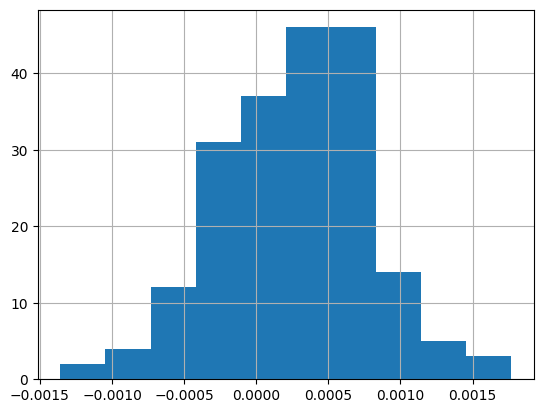

In [112]:
coef_df.loc[coef_df['modules'] == "pink", 'TRAB'].hist()

<Axes: >

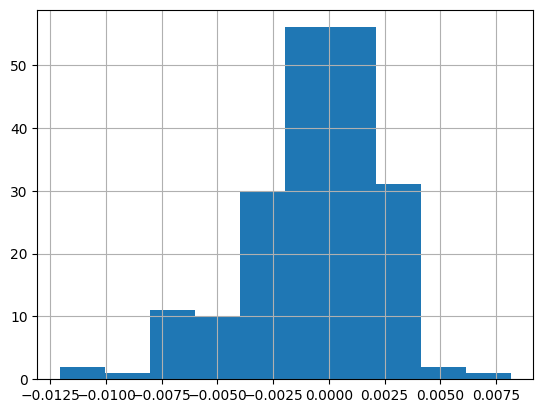

In [113]:
coef_df.loc[coef_df['modules'] == "pink", 'CD4N'].hist()

<Axes: >

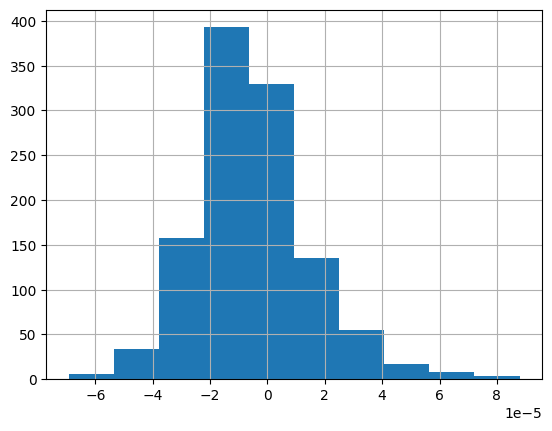

In [114]:
coef_df.loc[coef_df['modules'] == "blue", 'TRAB'].hist()

<Axes: >

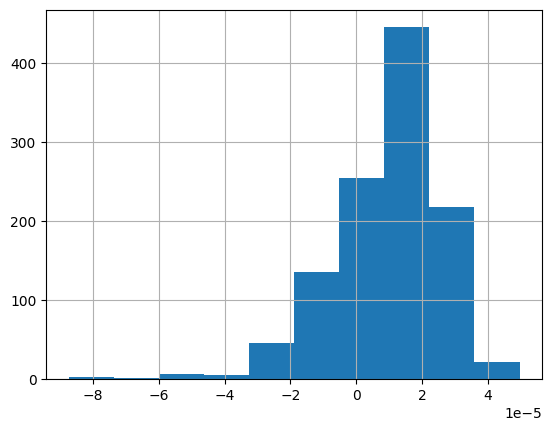

In [115]:
coef_df.loc[coef_df['modules'] == "blue", 'CD4N'].hist()

<Axes: >

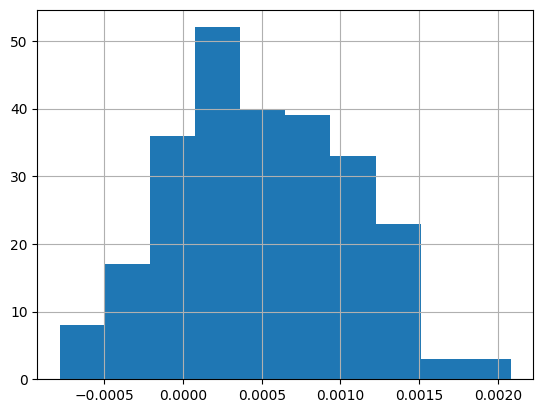

In [116]:
coef_df.loc[coef_df['modules'] == "black", 'TRAB'].hist()

<Axes: >

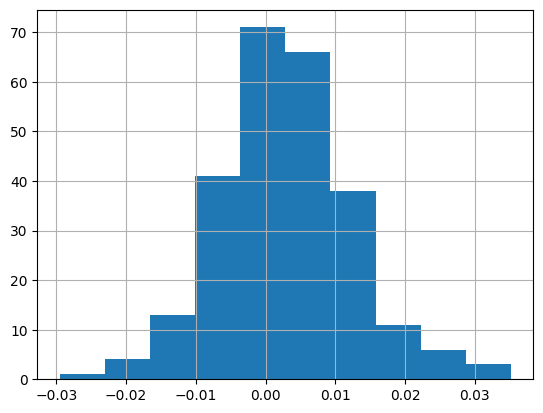

In [117]:
coef_df.loc[coef_df['modules'] == "black", 'CD4N'].hist()

<Axes: >

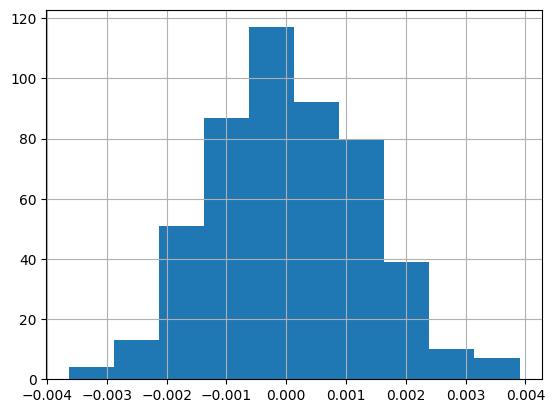

In [118]:
coef_df.loc[coef_df['modules'] == "brown", 'TRAB'].hist()

<Axes: >

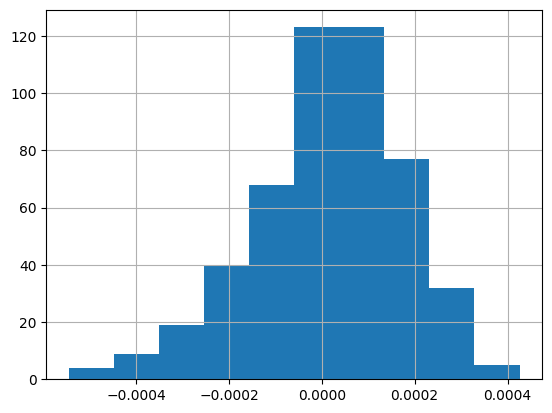

In [119]:
coef_df.loc[coef_df['modules'] == "brown", 'CD4N'].hist()